In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from time import time
import matplotlib.pyplot as plt

In [6]:
#Load data
dataset_path = "../data/UT_HAR_OG"
with h5py.File(dataset_path + "/data/X.h5", "r") as f:
    X = torch.tensor(f["X"][:])

with h5py.File(dataset_path + "/label/y.h5", "r") as f:
    y = torch.tensor(f["y"][:])

X_train_val, X_test, y_train_val, y_test = train_test_split(X,y,test_size=0.3, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42)

In [3]:
global_mean = X_train.mean(dim=(0,1))
global_std = X_train.std(dim=(0, 1)) + 1e-6  # Compute std over samples and time, add epsilon to avoid division by zeros

X_train = (X_train - global_mean) / global_std
X_val = (X_val - global_mean) / global_std
X_test = (X_test - global_mean) / global_std

In [8]:
decimation_factor = 1
print(X_train.shape)
X_train_decimated = X_train[:, ::decimation_factor, :]
X_val_decimated = X_val[:,::decimation_factor,:]
X_test_decimated = X_val[:,::decimation_factor,:]
print(X_train_decimated.shape)

torch.Size([311, 11301, 180])
torch.Size([311, 11301, 180])


In [9]:
# Fit PCA on training data
num_components = 90
data_flattened_train = X_train.reshape(-1, X_train.shape[2]).cpu().numpy()
pca = PCA(n_components=num_components)
pca = pca.fit(data_flattened_train)
# Define a function to apply PCA
def apply_pca(data, pca, num_components):
    # Flatten sample and time dimensions
    data_flattened = data.reshape(-1, data.shape[2]).cpu().numpy()
    # Apply PCA transformation
    data_pca = pca.transform(data_flattened)
    # Convert back to PyTorch tensor and reshape to original 3D format
    data_pca = torch.tensor(data_pca, dtype=torch.float32).reshape(
        data.shape[0], data.shape[1], num_components
    )
    return data_pca

# Apply PCA to training, validation, and test datasets
X_train_pca = apply_pca(X_train, pca, num_components)
X_val_pca = apply_pca(X_val, pca, num_components)
X_test_pca = apply_pca(X_test, pca, num_components)
print(X_val_pca.shape)

torch.Size([78, 11301, 90])


In [10]:
#Create datasets 
class HARData(Dataset):
    def __init__(self,X,y):
        super().__init__()
        self.X = torch.tensor(X,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.long)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
train_dataset = HARData(X_train_pca, y_train)
val_dataset = HARData(X_val_pca, y_val)
test_dataset = HARData(X_test_pca, y_test)


/tmp/ipykernel_360096/997440288.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X,dtype=torch.float32)
/tmp/ipykernel_360096/997440288.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y,dtype=torch.long)


In [11]:
#Def training function
def train(model, train_loader, test_loader, criterion, optimizer, epochs):
    model.train()
    train_acc = []
    train_loss = []

    test_acc = []
    test_loss = []

    for epoch in range(epochs):
        tic = time()
        avg_train_acc = 0
        avg_train_loss = 0
        total_train_samples = 0

        for x,y in train_loader:
            outputs = model(x)
            loss = criterion(outputs,y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_train_loss += loss.item() * x.size(0)
            avg_train_acc += compute_acc(outputs,y) 
            total_train_samples += x.size(0)
            
        avg_train_acc  /= total_train_samples
        avg_train_loss /= total_train_samples

        train_acc.append(avg_train_acc)
        train_loss.append(avg_train_loss)
        
        avg_test_acc = 0
        avg_test_loss = 0
        total_test_samples = 0
        for x,y in test_loader:
            with torch.no_grad():
                outputs = model(x)
                loss = criterion(outputs,y)
               
                avg_test_loss += loss.item() * x.size(0)
                avg_test_acc += compute_acc(outputs,y) 
                total_test_samples += x.size(0)

        avg_test_acc  /= total_test_samples
        avg_test_loss /= total_test_samples

        test_acc.append(avg_test_acc)
        test_loss.append(avg_test_loss)

        toc = time()

        print(f'Epoch {epoch+1}/{epochs} - {toc-tic:.0f}s - Avg train loss: {avg_train_loss} \
              - Avg train acc: {avg_train_acc} - Avg test loss: {avg_test_loss} \
              - Avg test acc: {avg_test_acc}')        

    return train_acc, train_loss, test_acc, test_loss


def compute_acc(outputs, y):
    _, predicted = torch.max(outputs,1)
    correct = (predicted==y).sum().item()
    return correct


In [12]:
class DenseNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,num_classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x
    
input_size = X_train_pca.shape[1]*X_train_pca.shape[2]
print(input_size)
num_classes = len(np.unique(y_train))
model = DenseNetwork(input_size,num_classes)

1017090


In [13]:
train_dataloader = DataLoader(train_dataset,batch_size=1,shuffle=True)
test_dataloader = DataLoader(val_dataset,batch_size=1,shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=1e-3)

train_acc, train_loss, test_acc, test_loss = train(model,train_dataloader,test_dataloader,criterion,optimizer,10)

Epoch 1/10 - 106s - Avg train loss: 119.80962498267317               - Avg train acc: 0.4115755627009646 - Avg test loss: 330.8602903981519               - Avg test acc: 0.47435897435897434
Epoch 2/10 - 108s - Avg train loss: 62.78428149122047               - Avg train acc: 0.6141479099678456 - Avg test loss: 24.562893836778105               - Avg test acc: 0.6923076923076923
Epoch 3/10 - 139s - Avg train loss: 15.805724729672137               - Avg train acc: 0.6141479099678456 - Avg test loss: 18.10677312198696               - Avg test acc: 0.5512820512820513
Epoch 4/10 - 166s - Avg train loss: 6.828958653566912               - Avg train acc: 0.6366559485530546 - Avg test loss: 7.576963912368788               - Avg test acc: 0.5
Epoch 5/10 - 174s - Avg train loss: 5.240225330256666               - Avg train acc: 0.5594855305466238 - Avg test loss: 9.871507118173039               - Avg test acc: 0.5897435897435898
Epoch 6/10 - 178s - Avg train loss: 4.7915050799278935               - 

In [14]:
def plot_loss_acc(train_acc, train_loss, test_acc, test_loss,num_epochs):
    epochs = list(range(1, num_epochs + 1))
    # Plot Loss
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss', marker='o')
    plt.plot(epochs, test_loss, label='Test Loss', marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Test Loss')
    plt.legend()
    plt.xticks(epochs)
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
    plt.plot(epochs, test_acc, label='Test Accuracy', marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train vs Test Accuracy')
    plt.legend()
    plt.xticks(epochs)
    plt.grid(True)
    
    # Display the plots
    plt.tight_layout()  # Adjust layout to avoid overlap


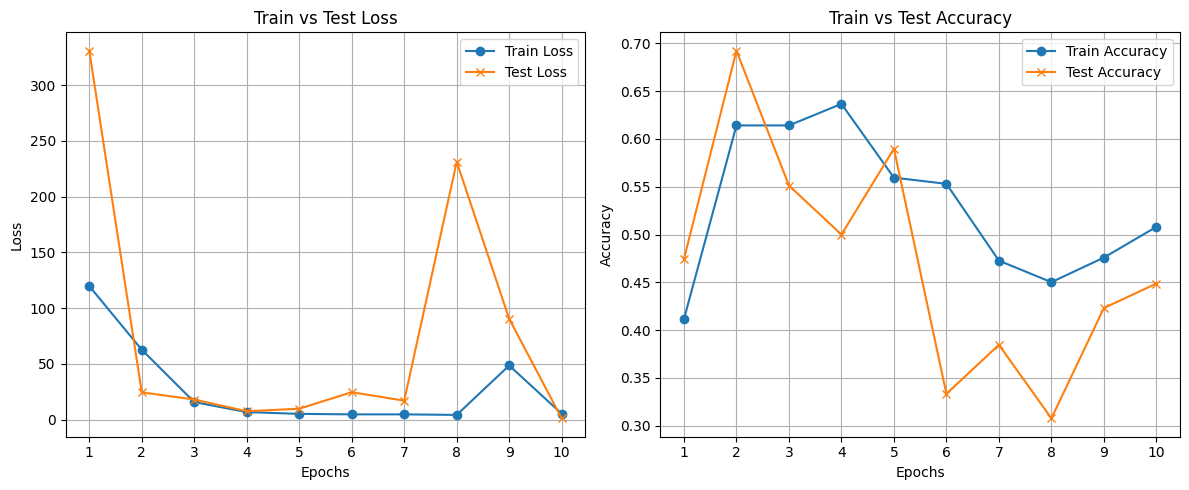

In [15]:
plot_loss_acc(train_acc,train_loss,test_acc,test_loss,10)